<a href="https://colab.research.google.com/github/Radperia/SIGNATE_student_2020/blob/master/SIGNATE_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Aug 25 07:36:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 9.8MB/s 
     |████████████████████████████████| 317kB 26.2MB/s 
     |████████████████████████████████| 7.2MB 55.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 1.4MB 53.0MB/s 
     |████████████████████████████████| 778kB 47.3MB/s 
     |████████████████████████████████| 3.0MB 50.8MB/s 
     |████████████████████████████████| 112kB 56.6MB/s 
     |████████████████████████████████| 4.4MB 47.8MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 163kB 58.6MB/s 
     |████████████████████████████████| 122kB 64.2MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 1.1MB 48.2MB/s 
     |████████████████████████████████| 890kB 50.3MB/s 
     |████████████████████████████████| 122kB 59.1MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 71kB 10.8MB/

In [3]:
import os, gc, sys
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from simpletransformers.classification import ClassificationModel
import torch

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
SEED = 2020
BASE_PATH = 'drive/My Drive/SIGNATE/'
TEXT_COL = "description"
TARGET = "jobflag"
NUM_CLASS = 4
N_FOLDS = 4

In [5]:
def metric_f1(labels, preds):
    return f1_score(labels, preds, average='macro')

In [6]:
def seed_everything(seed):
    """for reproducibility.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [7]:
train = pd.read_csv(BASE_PATH+"augmented_data.csv").drop(['id'], axis=1)
train = train.rename(columns={TEXT_COL:'text', TARGET:'label'})
train['label'] -= 1

test = pd.read_csv(BASE_PATH+"test.csv")
test = test.rename(columns={TEXT_COL:'text'}).drop(['id'], axis=1)

In [8]:
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
train['fold_id'] = -1
for fold, (train_idx, valid_idx) in enumerate(kfold.split(train.index, train['label'])):
    train.loc[train.iloc[valid_idx].index, 'fold_id'] = fold

X_train = train.loc[train['fold_id']!=0]
X_valid = train.loc[train['fold_id']==0]

In [9]:
params = {
    "output_dir": "outputs/",
    "max_seq_length": 128,
    "train_batch_size": 128,
    "eval_batch_size": 64,
    "num_train_epochs": 2,
    "learning_rate": 1e-5,
    "manual_seed":SEED,
}
model = ClassificationModel('bert', 'bert-base-cased', num_labels=4,
                            args=params, use_cuda=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [10]:
model.train_model(X_train)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:282: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [11]:
result, model_outputs, wrong_predictions = model.eval_model(X_valid, f1=metric_f1)
print(result)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:754: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



{'mcc': 0.980589504979097, 'f1': 0.9829806199470823, 'eval_loss': 0.049278992144778995}


In [12]:
y_pred, raw_outputs = model.predict(test['text'])
print(y_pred)


[3 2 2 ... 0 2 2]


In [13]:
test = pd.read_csv(BASE_PATH+"test.csv")
submit = pd.DataFrame({'index':test['id'], 'pred':y_pred+1})
submit

,index,pred
0,2931,4
1,2932,3
2,2933,3
3,2934,1
4,2935,3
...,...,...
1738,4669,1
1739,4670,4
1740,4671,1
1741,4672,3


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


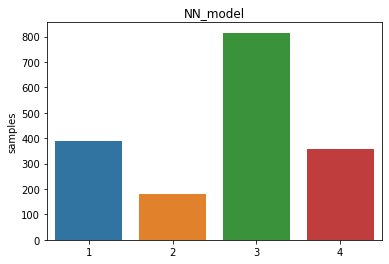

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

flag_vals = submit.pred.value_counts()
sns.barplot(flag_vals.index, flag_vals)
plt.gca().set_ylabel('samples')
plt.gca().set_title('NN_model')
plt.show()

In [15]:
submit.to_csv('NN_submit_cv0982.csv', index=False)

from google.colab import files
files.download('NN_submit_cv0982.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>